In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

#### Define the model

In [2]:
class SLM(torch.nn.Module):

    def __init__(
        self,
        n_nodes: int,
        g: float,
        f: float,
        h: float,
        eta: float,
        n_inputs: int,
        n_outputs: int,
    ):
        super().__init__()

        # Network parameters
        self.n_nodes = n_nodes

        # Node parameters
        self.a = torch.nn.Parameter(-5 * torch.rand(n_nodes))
        self.g = g
        self.eta = eta * torch.sqrt(torch.tensor(h))
        if isinstance(f, (int, float)):
            self.f = f * torch.ones(n_nodes)
        else:
            self.f = 60 * torch.rand(n_nodes) + 20
        self.f = torch.nn.Parameter(2 * torch.pi * self.f)

        # Simulation parameters
        self.h = h

        # Recurrent connections
        self.W_rec = torch.nn.Parameter(torch.rand((n_nodes, n_nodes)) * 0.1)
        # Input to hidden layer
        self.W_input = torch.nn.Linear(n_inputs, n_nodes)
        # Output layer
        self.W_output = torch.nn.Linear(n_nodes, n_outputs)

    def __ode(self, z: torch.Tensor, a: torch.Tensor, w: torch.Tensor):
        return z * (a + 1j * w - torch.abs(z * z))

    def loop(self, z_t: torch.Tensor, I_ext: torch.Tensor):

        z_t = (
            z_t
            + self.h * self.__ode(z_t, self.a, self.f)
            + self.h * self.g * (self.W_rec * (z_t[:, None] - z_t[..., None])).sum(-1)
            + self.h * self.W_input(I_ext)
            + self.eta * torch.randn(z_t.shape)
            + self.eta * 1j * torch.randn(z_t.shape)
        )

        return z_t

    def forward(self, n_trials: int, n_times: int, input: torch.Tensor):

        rec_z_t = torch.zeros(n_trials, n_times, self.n_nodes, dtype=torch.complex64)

        z_t = self.h * torch.randn(n_trials, self.n_nodes) + 1j * self.h * torch.randn(
            n_trials, self.n_nodes
        )

        z_t = torch.autograd.Variable(z_t)

        for t in range(n_times):
            z_t = self.loop(z_t, input[t])
            rec_z_t[:, t, :] = z_t

        output = {}
        output["rec"] = rec_z_t
        output["output"] = self.W_output(z_t.real)

        return output

#### Evaluation function

In [3]:
# run inference on test set
def evaluate_model(data_loader, epoch=None, batch=None):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        # loop over batches in data loader
        for i, (images, labels) in enumerate(data_loader):
            # reshape batch
            images = images.reshape(batch_size_test, 1, 50 * 50)
            images = images.permute(2, 0, 1)
            n_times, n_trials, _ = images.shape
            # run model inference - record true returns dynamics
            output = model.forward(n_trials, n_times, images)
            prediction = output["output"]
            # compute loss + number of correct predictions
            test_loss += loss(prediction, labels).item()
            pred_label = prediction.data.max(1, keepdim=True)[1]
            correct += pred_label.eq(labels.data.view_as(pred_label)).sum()
    # compute loss and accuracy
    test_loss /= len(data_loader)
    accuracy = 100.0 * correct / len(data_loader.dataset)

    return accuracy.item()

#### Simulate example    

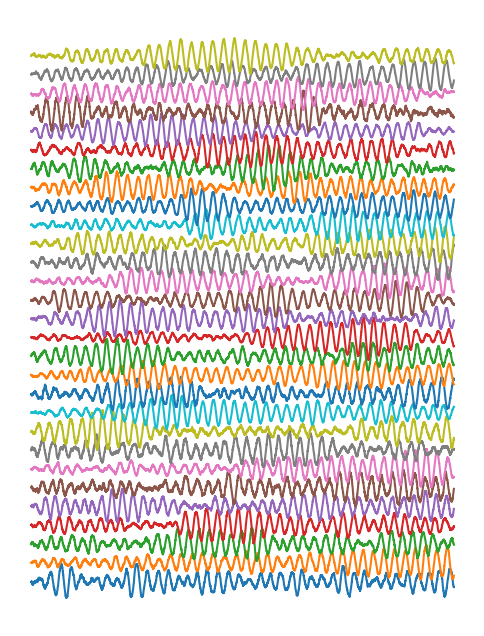

In [4]:
T = 1
h = 1e-4
n_trials = 10
n_times = int(T // h)
n_nodes = 29
npixels = 50

input = torch.zeros((n_times, n_trials, 1))
model = SLM(n_nodes, 1, 40, h, 1e-1, 1, 1)
model.a = torch.nn.Parameter(torch.ones(n_nodes) * -5)
out = model.forward(n_trials, n_times, input)

out = out["rec"].cpu().detach().numpy()

out = (out - out.mean(1)[:, None, :]) / out.std(1)[:, None, :]

plt.figure(figsize=(6, 8))
for i in range(29):
    plt.plot(out[0, :, i].real + (i * 2))
plt.axis("off");

In [5]:
def generate_input(T, h, label, sigma=0.1):
    assert label in [0, 1]
    n_times = int(T // h)
    times = torch.linspace(0, T, n_times)
    I = torch.zeros(n_times)
    # Choose stimuli
    I_0, I_1 = np.random.choice([1, 2, 3, 4, 5], 2, replace=False)

    I[torch.logical_and(times >= 0, times <= 0.2)] = I_0

    if label == 0:
        I[torch.logical_and(times >= 5.0, times <= 0.7)] = I_0
        I[torch.logical_and(times >= 0.8, times <= 1.0)] = I_1
    else:
        I[torch.logical_and(times >= 5.0, times <= 0.7)] = I_1
        I[torch.logical_and(times >= 0.8, times <= 1.0)] = I_0
    # Add noise
    I = I + torch.randn(n_times) * sigma
    return I, label


class InputDataset(Dataset):
    def __init__(self, T, h, size, sigma=0.1):
        self.T = T
        self.h = h
        self.size = size
        self.sigma = sigma

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        label = np.random.choice([0, 1])
        I, label = generate_input(self.T, self.h, label, self.sigma)
        return I.float(), torch.tensor(label, dtype=torch.long)

In [6]:
# Use MNIST as input
dim_input = 1

# 10 MNIST classes
dim_output = 10

# batch size of the test set
batch_size_train = 100
batch_size_test = 1000

# load dataset
size_validation = 1000  # size of validation dataset
train_set = torchvision.datasets.MNIST(
    root="data",
    train=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(npixels), torchvision.transforms.ToTensor()]
    ),
    download=True,
)
test_set = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(npixels), torchvision.transforms.ToTensor()]
    ),
)
train_set, valid_set = torch.utils.data.random_split(
    train_set, [len(train_set) - size_validation, size_validation]
)

# data loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size_train, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_set, batch_size=batch_size_test, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size_test, shuffle=False
)

model = SLM(n_nodes, 1, None, h, 1e-4, 1, 10)

# bce loss and optimizer for training
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

100%|██████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 6.32MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 316kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.52MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.05MB/s]


In [ ]:
epochs = 10
batch_size = 50
# training loop
best_eval = 0.0
for epoch in tqdm(range(epochs), total=epochs):
    tqdm.write(f"epoch {epoch}")
    # loop over batches for one epoch
    for batch, (images, labels) in tqdm(
        enumerate(train_loader), total=len(train_loader)
    ):
        # set model into train mode
        model.train()

        # reshape samples
        images = images.reshape(batch_size_train, 1, 50 * 50)

        # dimensions: time x batch x 1
        images = images.permute(2, 0, 1)
        n_times, n_trials, _ = images.shape

        # zero gradients
        optimizer.zero_grad()

        # predict
        output = model.forward(n_trials, n_times, images)
        prediction = output["output"]

        # compute loss
        train_loss = loss(prediction, labels)

        # compute gradients
        train_loss.backward()

        # update parameters
        optimizer.step()

        if batch % 100 == 0:
            test_acc = evaluate_model(test_loader, epoch, batch)
            tqdm.write(f"epoch {epoch} batch {batch}: test acc {test_acc:.2f}")

  0%|                                                    | 0/10 [00:00<?, ?it/s]

epoch 0



                                                                                
  0%|                                                    | 0/10 [00:20<?, ?it/s]
%|                                                   | 0/590 [00:20<?, ?it/s]
%|                                         | 1/590 [00:20<3:20:27, 20.42s/it]

epoch 0 batch 0: test acc 12.22



%|▏                                        | 2/590 [00:22<1:32:43,  9.46s/it]
%|▏                                          | 3/590 [00:24<58:24,  5.97s/it]
%|▎                                          | 4/590 [00:25<41:47,  4.28s/it]
%|▎                                          | 5/590 [00:27<33:28,  3.43s/it]
%|▍                                          | 6/590 [00:29<27:53,  2.86s/it]
%|▌                                          | 7/590 [00:31<25:10,  2.59s/it]
%|▌                                          | 8/590 [00:33<23:09,  2.39s/it]
%|▋                                          | 9/590 [00:35<21:42,  2.24s/it]
%|▋                                         | 10/590 [00:37<20:21,  2.11s/it]
%|▊                                         | 11/590 [00:38<19:04,  1.98s/it]
%|▊                                         | 12/590 [00:40<18:59,  1.97s/it]
%|▉                                         | 13/590 [00:42<18:01,  1.88s/it]
%|▉                                         | 14/590 [00:44<18:

epoch 0 batch 100: test acc 31.47



%|███████                                  | 102/590 [03:44<44:14,  5.44s/it]
%|███████▏                                 | 103/590 [03:45<34:59,  4.31s/it]
%|███████▏                                 | 104/590 [03:47<28:41,  3.54s/it]
%|███████▎                                 | 105/590 [03:49<23:59,  2.97s/it]
%|███████▎                                 | 106/590 [03:50<20:58,  2.60s/it]
%|███████▍                                 | 107/590 [03:52<18:37,  2.31s/it]
%|███████▌                                 | 108/590 [03:54<17:29,  2.18s/it]
%|███████▌                                 | 109/590 [03:56<17:22,  2.17s/it]
%|███████▋                                 | 110/590 [03:58<16:40,  2.08s/it]
%|███████▋                                 | 111/590 [04:00<16:21,  2.05s/it]
%|███████▊                                 | 112/590 [04:01<14:57,  1.88s/it]
%|███████▊                                 | 113/590 [04:03<14:23,  1.81s/it]
%|███████▉                                 | 114/590 [04:05<13:

In [ ]:
torch.sort(model.f / (2 * torch.pi))

In [ ]:
model.a

In [ ]:
plt.figure(figsize=(6, 8))
out = output["rec"].cpu().detach().numpy()
out = (out - out.mean(1)[:, None, :]) / out.std(1)[:, None, :]

for i in range(50):
    plt.plot(out[4, :, i].real + (i * 2))
plt.axis("off");

In [ ]:
T = 2
h = 1e-4
n_trials = 10
n_times = int(T // h)
n_nodes = 29

input = torch.zeros((n_times, n_trials, 1))

out = model.forward(n_trials, n_times, input)

out = out["rec"].cpu().detach().numpy()
out = out[..., torch.argsort(model.f)]

out = (out - out.mean(1)[:, None, :]) / out.std(1)[:, None, :]
plt.figure(figsize=(6, 8))
for i in range(29):
    plt.plot(out[0, :, i].real + (i * 2))
plt.axis("off");

In [10]:
torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device(type='cpu')